In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly
import bokeh
import re
from collections import Counter

In [2]:
# Definovanie cesty k súborom (použi raw string, aby sa predišlo problémom so spätnými lomítkami)
file_morphodita = r"C:\Users\marti\Diplomovka\morphodita\words.xlsx"
file_stanza     = r"C:\Users\marti\Diplomovka\stanza\outputStanza.xlsx"
file_treetagger = r"C:\Users\marti\Diplomovka\TreeTagger\outputTreeTagger.xlsx"
file_udpipe     = r"C:\Users\marti\Diplomovka\UDPipe\UDPipe.xlsx"
file_control    = r"C:\Users\marti\Diplomovka\DiplomovkaOpravene.xlsx"

In [3]:
def clean_morphodita_lemma(lemma):
    if pd.isnull(lemma):
        return lemma
    lemma = str(lemma).strip()
    # Rozdelíme reťazec na základe znakov -, _ alebo `
    cleaned = re.split(r'[-_`]', lemma)[0]
    return cleaned

# Ak potrebuješ aj pôvodnú funkciu, ktorá len odstráni nadbytočné medzery (ak by si ju chcel použiť na iné dataset-y)
def clean_lemma(lemma):
    if pd.isnull(lemma):
        return lemma
    cleaned = str(lemma).strip()
    # Nahradenie viacnásobných medzier jednou medzerou (ak je to potrebné)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    return cleaned

In [4]:
# Načítanie kontrolného datasetu a čistenie lemm
control_df = pd.read_excel(file_control)
control_df['Control_Lemma'] = control_df['Lemma'].apply(clean_lemma)
control_df['Control_Lemma']=control_df['Control_Lemma'].str.lower()
# Pridáme pomocný stĺpec 'Occurrence' – poradové číslo výskytu tokenu
control_df['Occurrence'] = control_df.groupby('Token').cumcount()

# Vytvorenie základného agregovaného DataFrame s tokenmi, kontrolným očisteným lemmom a Occurrence
aggregated = control_df[['Token', 'Control_Lemma', 'Occurrence']].copy()
print("Control dataset length:", len(aggregated))

# Definícia tagger dataset-ov
libraries = {
    'morphodita': file_morphodita,
    'stanza': file_stanza,
    'treetagger': file_treetagger,
    'udpipe': file_udpipe
}

for lib, path in libraries.items():
    df = pd.read_excel(path)
    print(f"Dataset {lib} length: {len(df)}")
    
    # Podľa taggera vyberieme vhodnú funkciu a identifikátor:
    if lib == 'morphodita':
        df['Lemma_clean'] = df['Lemma'].apply(clean_morphodita_lemma)
        df['Lemma_clean']=df['Lemma_clean'].str.lower()
        id_col = 'Sentence_ID'  # Morphodita používa Sentence_ID
    else:
        df['Lemma_clean'] = df['Lemma'].apply(clean_lemma)
        df['Lemma_clean']=df['Lemma_clean'].str.lower()
        id_col = 'ID'         # Ostatné dataset-y predpokladajú stĺpec ID
    
    # Pridáme stĺpec Occurrence pre daný dataset
    df['Occurrence'] = df.groupby('Token').cumcount()
    
    # Vyberieme len relevantné stĺpce: Token, Occurrence, očistené lemma a identifikátor
    df_subset = df[['Token', 'Occurrence', 'Lemma_clean', id_col]].copy()
    # Premenujeme stĺpce, aby bolo jasné, z ktorého datasetu pochádzajú
    df_subset.rename(columns={
        'Lemma_clean': f'{lib}_Lemma',
        id_col: f'{lib}_{id_col}'
    }, inplace=True)
    
    # Zlúčenie (merge) s agregovaným DataFrame na základe dvojice (Token, Occurrence)
    aggregated = pd.merge(aggregated, df_subset, on=['Token', 'Occurrence'], how='left')
    
    # Vypočítame boolean stĺpec, ktorý hovorí, či sa očistené lemma z taggera zhoduje s kontrolným
    aggregated[f'{lib}_Match'] = (aggregated[f'{lib}_Lemma'] == aggregated['Control_Lemma']).fillna(False)

# Ak nepotrebuješ pomocný stĺpec Occurrence, môžeš ho odstrániť:
# aggregated.drop(columns=['Occurrence'], inplace=True)

# Výpis výsledného DataFrame (prvých pár riadkov)
print(aggregated.head())

Control dataset length: 1199
Dataset morphodita length: 1215
Dataset stanza length: 1199
Dataset treetagger length: 1199
Dataset udpipe length: 1199
     Token Control_Lemma  Occurrence morphodita_Lemma  morphodita_Sentence_ID  \
0       Je           byť           0              byť                     1.0   
1       už            už           0               už                     1.0   
2    skoro         skoro           0            skoro                     1.0   
3  október       október           0          október                     1.0   
4        a             a           0                a                     1.0   

   morphodita_Match stanza_Lemma  stanza_ID  stanza_Match treetagger_Lemma  \
0              True          byť          1          True              byť   
1              True           už          2          True               už   
2              True        skoro          3          True            skoro   
3              True      október          4         

In [5]:
match_columns = ['udpipe_Match', 'treetagger_Match', 'stanza_Match', 'morphodita_Match']

for col in match_columns:
    c = Counter(aggregated[col])
    total = c[True] + c[False]
    if total > 0:
        percentage = c[True] / total * 100
        print(f"{col}: {percentage:.2f}% match (True: {c[True]}, False: {c[False]})")
    else:
        print(f"{col}: No data available")

udpipe_Match: 93.74% match (True: 1124, False: 75)
treetagger_Match: 89.41% match (True: 1072, False: 127)
stanza_Match: 91.74% match (True: 1100, False: 99)
morphodita_Match: 89.82% match (True: 1077, False: 122)


In [6]:
# Uloženie výsledkov do Excel súboru, ak je to potrebné
aggregated.to_excel(r"C:\Users\marti\Diplomovka\AggregatedResults.xlsx", index=False)

C:\Users\marti\AppData\Local\Temp\ipykernel_22428\498150079.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Library', y='Match_Percentage', data=summary_df, palette='viridis')


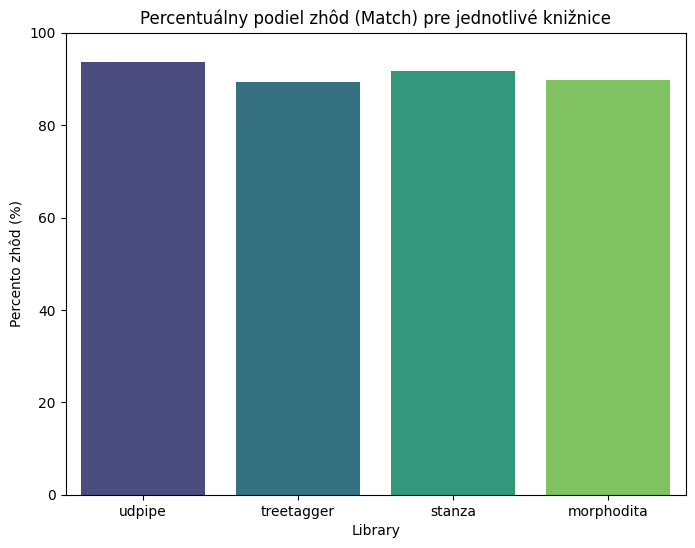

In [7]:
# Predpokladáme, že aggregated je už vytvorený DataFrame
library = ['udpipe', 'treetagger', 'stanza', 'morphodita']

# Vytvoríme zhrnutie: pre každú knižnicu spočítame percento True (Match)
data = []
for lib in library:
    # Počet tokenov, kde je hodnota nie-NaN (predpokladáme, že všetky sú booleovské)
    total = aggregated[f'{lib}_Match'].notnull().sum()
    count_true = aggregated[f'{lib}_Match'].sum()  # True sa sčíta ako 1
    percentage = (count_true / total * 100) if total > 0 else 0
    data.append({'Library': lib, 'Match_Percentage': percentage,
                 'Count_True': count_true, 'Total': total})

summary_df = pd.DataFrame(data)

# Vykreslenie bar chartu
plt.figure(figsize=(8, 6))
sns.barplot(x='Library', y='Match_Percentage', data=summary_df, palette='viridis')
plt.title('Percentuálny podiel zhôd (Match) pre jednotlivé knižnice')
plt.ylabel('Percento zhôd (%)')
plt.ylim(0, 100)
plt.show()

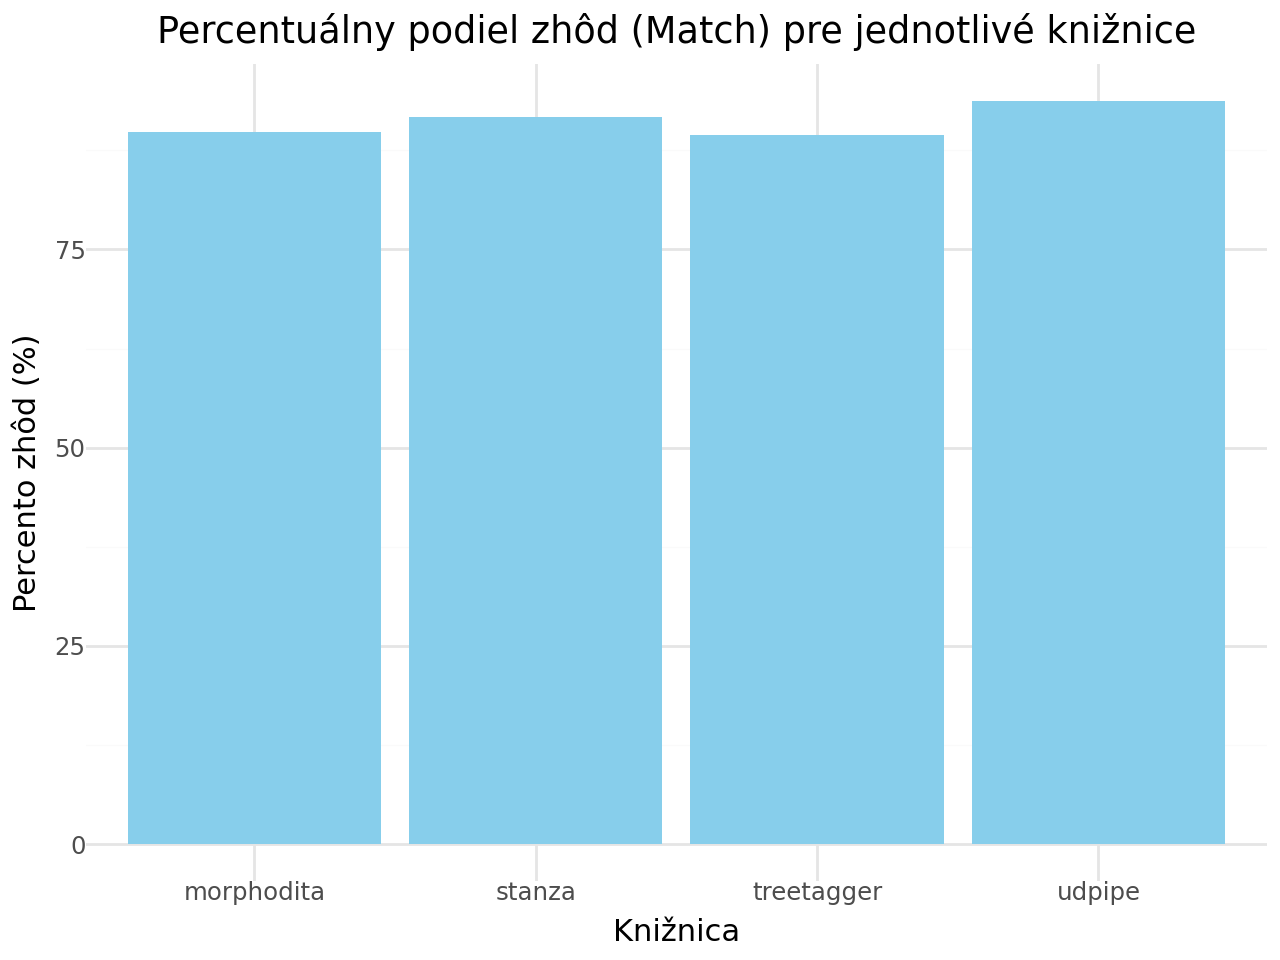

In [8]:
from plotnine import ggplot, aes, geom_bar, labs, theme_minimal

p = (ggplot(summary_df, aes(x='Library', y='Match_Percentage'))
     + geom_bar(stat='identity', fill='skyblue')
     + labs(title='Percentuálny podiel zhôd (Match) pre jednotlivé knižnice',
            x='Knižnica', y='Percento zhôd (%)')
     + theme_minimal())
p

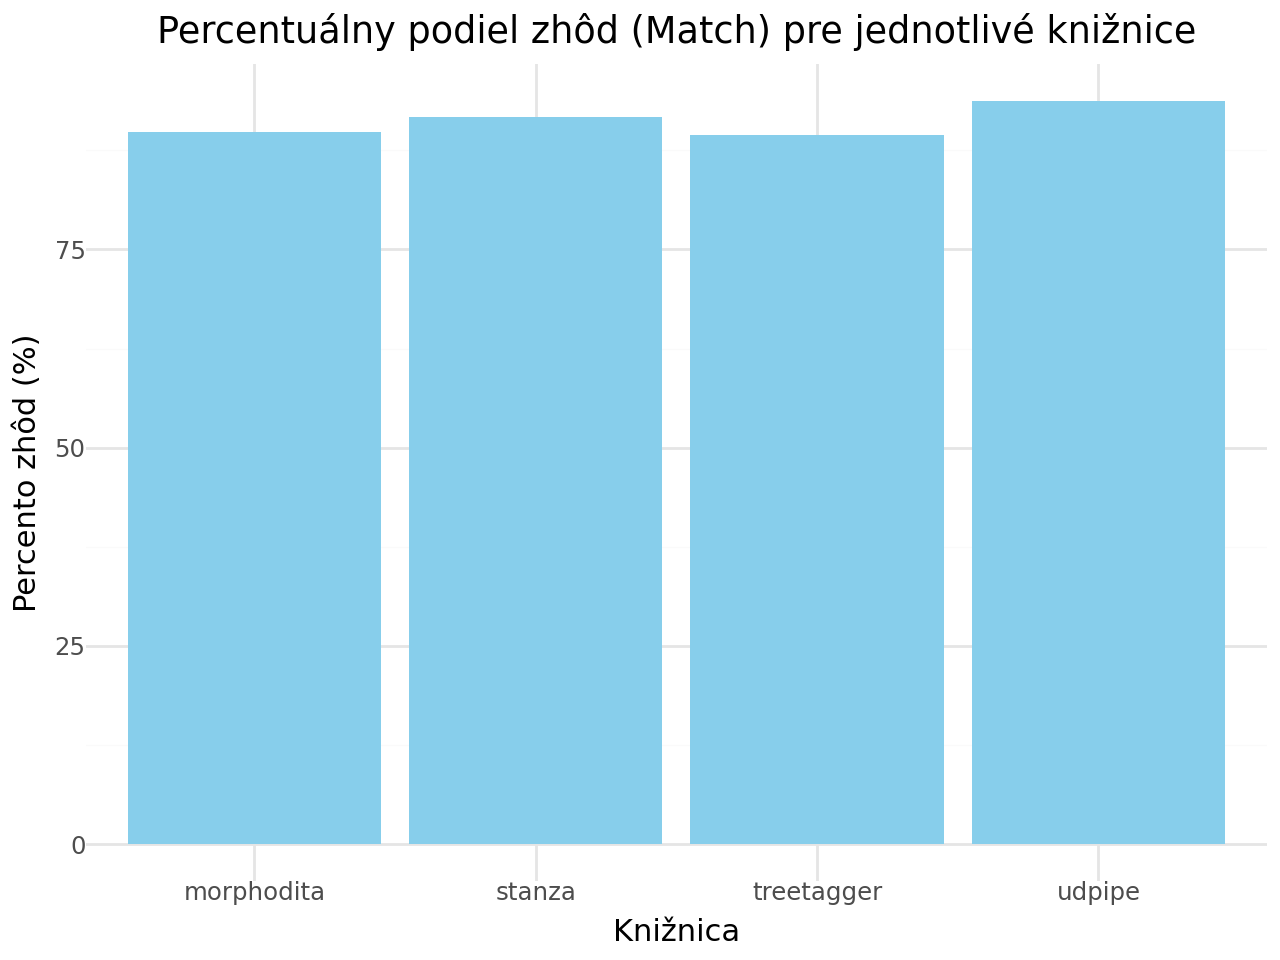

In [9]:
from IPython.display import display
display(p)

In [10]:
import plotly.express as px

fig = px.bar(summary_df, 
             x='Library', 
             y='Match_Percentage', 
             title='Percentuálny podiel zhôd (Match) pre jednotlivé knižnice',
             labels={'Match_Percentage': 'Percento zhôd (%)'},
             text='Match_Percentage')
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(yaxis_range=[0, 100])
fig.show()


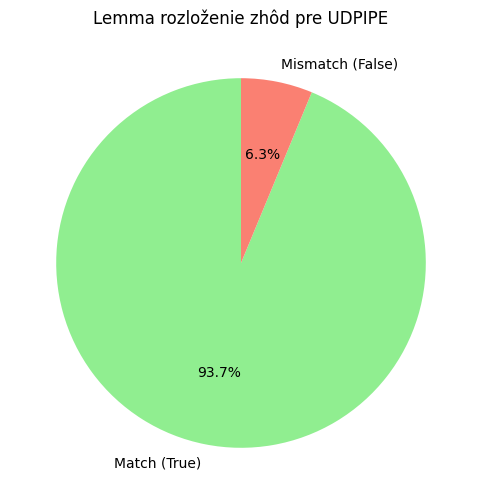

In [11]:
import matplotlib.pyplot as plt

c = aggregated['udpipe_Match'].value_counts()
labels = ['Match (True)', 'Mismatch (False)']
plt.figure(figsize=(6, 6))
plt.pie(c, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'salmon'])
plt.title('Lemma rozloženie zhôd pre UDPIPE')
plt.show()
